<img src="img/f_blue@2x.png" width="15%"/>

# Practical 2: Assessing Health Facilities Coverage
---
*29 October 2021* \
**Author**: Romain Goldenberg \@ Flowminder foundation

<br></br>

This exercise provides an example of how we can use GRID3 data within an application.

**The problem:** We want to assess health facility coverage for maternal healthcare in Kaduna state. We are interested in finding out which areas are over-stretched with a high number of women of child-bearing age (WOCBA) per health-facility. By identifying a target number of people per health facility, we can begin to highlight locations that may need further invention.

## Getting started
---
### Exercise Overview
---
Using geospatial analysis in Python, this demo will show an assessment of health facility coverage for maternal health using the GRID3 population data for Kaduna State.

In this exercise we are going to:

- Load some spatial data
- Subset the data to focus on points of interest
- Aggregate dataset using some basic geospatial techniques
- Try and identify connections between datasets to set targets

### Loading Packages
---

In [1]:
# General purpose libraries.
import pandas as pd
import os
import numpy as np

# Geospatial libraries.
import geopandas
import rasterio
from rasterio.plot import show
import folium
# Voronoi and Zonal statistics libraries
from geovoronoi import voronoi_regions_from_coords
from rasterstats import zonal_stats

# Visualization libraries.
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

### Loading Datasets
We have four datasets used in this example:

These datasets can be obtained from the GRID3 Nigeria Data portal at https://grid3.gov.ng/

>- [**Health facility locations**](https://grid3.gov.ng/dataset/kaduna-health-care-facilities-primary-secondary-and-tertiary/resources)
>- [**Ward boundaries**](https://grid3.gov.ng/dataset/kaduna-operational-ward-boundaries)
>- [**Gridded population**](https://grid3.gov.ng/dataset/national-population-estimates/resources)\
We provide an already prepared dataset with women aged 15-49 for Kaduna State
>- [**State boundary**](https://grid3.gov.ng/dataset/kaduna-state-administrative-boundaries)


In [2]:
# Path for the data folder
data_path = os.path.join(os.getcwd(), 'Data')

# Path to population (we will open it later with rasterio)
population = data_path + "/NGA_population_v1_2_agesex_f15_49_simple.tif"

# Below, we directly open the different shapefiles datasets with geopandas:
# 1- Health facilities
health_care = geopandas.read_file(
    data_path +
    "/health-care-facilities-primary-secondary-and-tertiary.geojson")
# 2- State boundaries
state_boundary = geopandas.read_file(
    data_path + "/state-administrative-boundaries.geojson")
# 3- Wards boundaries
wards = geopandas.read_file(data_path + "/operational-ward-boundaries.geojson")

## Filtering Public health facilities
---
We will view our health facilty data below.\
This includes data such as their location, the type of health centre (*primary, secondary, tertiary*), and whether it is private or publicly owned. An example of some of the data is shown below:

In [3]:
# Here, we select specific columns (of interest) to show,
# indicated by the different indexes (position of the column).
# display is used to show the data.
display(health_care.iloc[:, np.r_[1:3, 9, 11, 15, 19, 24]])

latitude  longitude               category  \
0     10.648418   7.041725  Primary Health Center   
1     10.725830   6.745430  Primary Health Center   
2     10.725047   6.745297  Primary Health Center   
3     10.769058   6.642158  Primary Health Clinic   
4     10.791455   6.636343  Primary Health Center   
...         ...        ...                    ...   
2245  10.927040   7.787299             Dispensary   
2246  11.020853   7.761741  Primary Health Center   
2247  10.979158   7.766452  Primary Health Center   
2248  10.970477   7.779581  Primary Health Clinic   
2249  11.046583   7.761747  Primary Health Clinic   

                                          name  \
0                           Labi Health Center   
1                          Mando Health Center   
2                          Gayam Health Center   
3                 Girezin Primary Health Carep   
4                   Kafanin Doka Health Center   
...                                        ...   
2245                        Tsakiya Dispensary   
2246            Wuciciri Primary Health Center   
2247                          Dan Arewa Clinic   
2248         Angwar Bisa Primary Health Clinic   
2249  Tudun Kusa Nursing Home And Maternity Ed   

                                           ownership ward_name  \
0        State Primary Healthcare Development Agency     Gayam   
1        State Primary Healthcare Development Agency     Gayam   
2        State Primary Healthcare Development Agency     Gayam   
3                                             Public     Gayam   
4     National Primary Healthcare Development Agency     Gayam   
...                                              ...       ...   
2245                                         Private  Wuciciri   
2246  National Primary Healthcare Development Agency  Wuciciri   
2247                                         Private  Wuciciri   
2248                                          Public  Wuciciri   
2249                                          Public  Wuciciri   

                      geometry  
0     POINT (7.04172 10.64842)  
1     POINT (6.74543 10.72583)  
2     POINT (6.74530 10.72505)  
3     POINT (6.64216 10.76906)  
4     POINT (6.63634 10.79145)  
...                        ...  
2245  POINT (7.78730 10.92704)  
2246  POINT (7.76174 11.02085)  
2247  POINT (7.76645 10.97916)  
2248  POINT (7.77958 10.97048)  
2249  POINT (7.76175 11.04658)  

[2250 rows x 7 columns]

For our example, we are only interested in public health centers. We will therefore filter the dataset below:

In [4]:
# We select places where "ownership" = "Public", in other words public health centers.
public_health_care = health_care.loc[health_care["ownership"] == "Public"]

# We display the results.
display(public_health_care.iloc[:, np.r_[1:3, 9, 11, 15, 19, 24]])

latitude  longitude               category  \
3     10.769058   6.642158  Primary Health Clinic   
12    10.707223   6.688533  Primary Health Center   
16    10.777357   6.180544  Primary Health Center   
19    10.649940   6.354280  Primary Health Center   
20    10.646690   6.351030  Primary Health Clinic   
...         ...        ...                    ...   
2236  11.051805   7.689320            Health Post   
2242  11.024940   7.775530  Primary Health Clinic   
2243  10.932492   7.785242            Health Post   
2248  10.970477   7.779581  Primary Health Clinic   
2249  11.046583   7.761747  Primary Health Clinic   

                                          name ownership     ward_name  \
3                 Girezin Primary Health Carep    Public         Gayam   
12                   Pole Wire's Health Center    Public         Gayam   
16        Kankangi Model Primary Health Center    Public       Kakangi   
19            Sabon Layi Primary Health Center    Public       Kakangi   
20            Ikon Allah Nursing And Maternity    Public       Kakangi   
...                                        ...       ...           ...   
2236              Kofar Kuyam Bana Health Post    Public  Unguwar Juma   
2242                      Bogari Health Clinic    Public      Wuciciri   
2243                       Rubuchi Health Post    Public      Wuciciri   
2248         Angwar Bisa Primary Health Clinic    Public      Wuciciri   
2249  Tudun Kusa Nursing Home And Maternity Ed    Public      Wuciciri   

                      geometry  
3     POINT (6.64216 10.76906)  
12    POINT (6.68853 10.70722)  
16    POINT (6.18054 10.77736)  
19    POINT (6.35428 10.64994)  
20    POINT (6.35103 10.64669)  
...                        ...  
2236  POINT (7.68932 11.05180)  
2242  POINT (7.77553 11.02494)  
2243  POINT (7.78524 10.93249)  
2248  POINT (7.77958 10.97048)  
2249  POINT (7.76175 11.04658)  

[812 rows x 7 columns]

## Visualizing our datasets
---

All of our data is geospatial, meaning it has a relationship to spatial location. Our `health care` dataset is point(s) data, `wards` and `state_boundary` polygon(s) data. They are examples of [shapefile](https://gisgeography.com/spatial-data-types-vector-raster/) data. Our `population` dataset is instead an example of [raster](https://gisgeography.com/spatial-data-types-vector-raster/) data.\
So let's visualize our data on an interactive map.

Below is the first layer of our map, the `wards` of Kaduna state:

In [5]:
# explore() is a geopandas method to create interactive maps.
# we assign it to the variable 'kaduna_map', to add more map layers after.
kaduna_map = wards.explore(
    color="black",  # Use black color for borders.
    # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
    # and change the opacity of different elements.
    style_kwds=dict(fillColor="lightgrey",
                    fill=True,
                    opacity=1.,
                    fillOpacity=0,
                    interactive=True),
    tiles="Esri WorldImagery",  # Use "Esri WorldImagery" background tiles.
    tooltip=False,  # Do not show tooltip when hovering on wards.
    popup="ward_name",  # Show the name of the ward on click.
    # Do not show the column label "ward_name" in the popup.
    popup_kwds=dict(labels=False),
    smooth_factor=0,  # Prevent smoothing of the polygons edges.
    name="wards"  # Name of the layer in the map.
)

Then we continue with our second layer, the `public_health_care` dataset:

In [6]:
public_health_care.explore(
    m=kaduna_map,  # Pass the previous map object 'kaduna_map'.
    column="category",  # Make choropleth based on "category" column.
    tooltip="name",  # Show "name" value in tooltip (on hover)
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    # Show the selected values in popup (on click).
    popup=["category", "name", "ownership"],
    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    marker_kwds=dict(radius=5),  # Size of the points.
    # Styling instructions. We draw small black circles around our points,
    # and change the opacity of different elements.
    style_kwds=dict(color="black",
                    weight=1,
                    fill=True,
                    opacity=0.5,
                    fillOpacity=0.8),
    name="health_care"  # Name of the layer in the map.
)

# Use the folium library (which Geopandas is based on for interactive mapping) to add layer control
folium.LayerControl().add_to(kaduna_map)

We can now display our map:

In [7]:
kaduna_map

Now, let's visualize our raster data. We will use a different strategy for the sake of this exercise, as the data size of `population` is much larger. We will then produce here a simple static map.\
We will use here the `rasterio` library to manage and open our raster data:

In [8]:
# Use rasterio to import the raster data
with rasterio.open(population) as pop:
    data_pop = pop.dataset_mask()  # Returns the valid data mask.
    img_pop = pop.read(1)  # Returns the full image.
    nodata_pop = pop.nodata  # Returns the value of "no data" cells

Then, we can map our `population` dataset using `imshow()` from the `matplotlib` library.

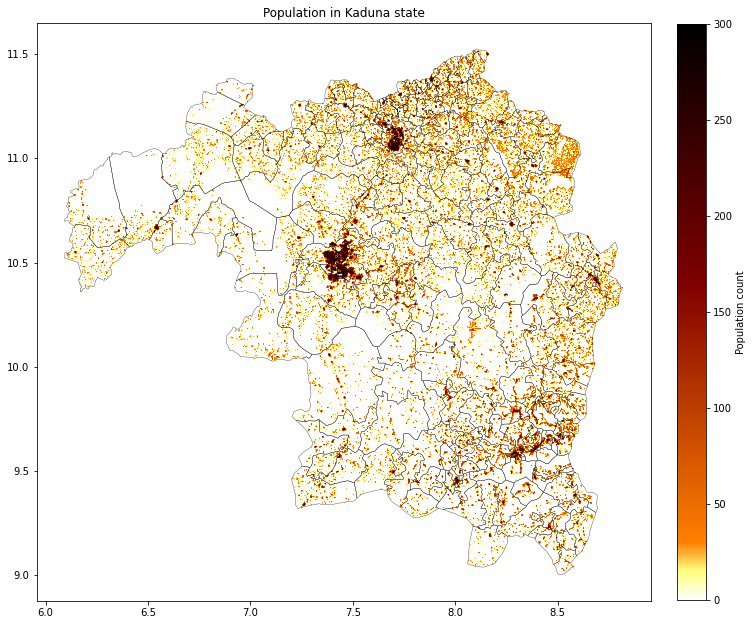

In [9]:
# We first define a normalization for our colormap (range of colors)
norm = mcolors.TwoSlopeNorm(vmin=0, vmax=300., vcenter=30)

# Then, we create a new figure
fig, ax = plt.subplots(figsize=(12, 12))

# We first plot the population data. We use 'afmhot_r' as color scheme, normalize the color scheme,
# and provide the geographic extent of the data in 'extent'.
plot_pop = ax.imshow(data_pop,
                     cmap="afmhot_r",
                     norm=norm,
                     extent=rasterio.plot.plotting_extent(pop))
# Then, we plot our wards on top of the population data
wards.plot(edgecolor='black', facecolor='none', linewidth=0.3, alpha=1, ax=ax)
# Finally, we add a colorbar to the map
fig.colorbar(plot_pop,
             fraction=0.043,
             pad=0.04,
             label='Population count',
             ax=ax)
plt.title('Population in Kaduna state')  # Title for our plot
plt.show()  # Show the figure

## Computing Voronoi Polygons
---
We are interested in finding out the health facility coverage across space.

- Idea: optimize the partitioning of the area into polygons such that each polygon contains one health facility.
- Method: [Voronoi](https://en.wikipedia.org/wiki/Voronoi_diagram) Polygon

<figure>
  <img
  src="img/Voronoi_growth_euclidean.gif"
  alt="Voronoi."
  width="20%" 
  align="center">
  <figcaption>
      <center>
          <i> Emergence of a Voronoi tessellation from points (from 
          <a href="https://en.wikipedia.org/wiki/Voronoi_diagram">Wikipedia</a></i>)
      </center>
  </figcaption>
</figure>

### Check on the CRS (Coordinate Reference System)
---

Before running this algorithm, we need to make sure our datasets have the same CRS. 

In [10]:
# Using .crs (from geopandas), we easily obtain information on the dataset CRS.
public_health_care.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Currently, our data is in WGS 84 (epsg:4326), a latitude/longitude coordinate system based on the Earth's center of mass (very common, used by the Global Positioning System among others). For our purpose, it is better to use a local projected coordinate system, rather than a global geographic system (as we currently have) to avoid distortions in results due to the projection.

We will now switch our data to the local CRS epsg:26392, a projected coordinate system (position measurements in meters) corresponding to Minna / Nigeria Mid Belt.

In [11]:
# With .to_crs (from geopandas), we can easily reproject our data.
public_health_care = public_health_care.to_crs("epsg:26392")
state_boundary = state_boundary.to_crs("epsg:26392")
wards = wards.to_crs("epsg:26392")

Let's have a look at the new CRS:

In [12]:
public_health_care.crs

<Projected CRS: EPSG:26392>
Name: Minna / Nigeria Mid Belt
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Nigeria between 6°30'E and 10°30'E, onshore and offshore shelf.
- bounds: (6.5, 3.57, 10.51, 13.53)
Coordinate Operation:
- name: Nigeria Mid Belt
- method: Transverse Mercator
Datum: Minna
- Ellipsoid: Clarke 1880 (RGS)
- Prime Meridian: Greenwich

And a quick look at the data.\
You should now see a difference in the coordinates of our `geometry` column, compared to the first time we opened the data:

In [13]:
# We display the results.
display(public_health_care.iloc[:, np.r_[1:3, 9, 11, 15, 19, 24]])

latitude  longitude               category  \
3     10.769058   6.642158  Primary Health Clinic   
12    10.707223   6.688533  Primary Health Center   
16    10.777357   6.180544  Primary Health Center   
19    10.649940   6.354280  Primary Health Center   
20    10.646690   6.351030  Primary Health Clinic   
...         ...        ...                    ...   
2236  11.051805   7.689320            Health Post   
2242  11.024940   7.775530  Primary Health Clinic   
2243  10.932492   7.785242            Health Post   
2248  10.970477   7.779581  Primary Health Clinic   
2249  11.046583   7.761747  Primary Health Clinic   

                                          name ownership     ward_name  \
3                 Girezin Primary Health Carep    Public         Gayam   
12                   Pole Wire's Health Center    Public         Gayam   
16        Kankangi Model Primary Health Center    Public       Kakangi   
19            Sabon Layi Primary Health Center    Public       Kakangi   
20            Ikon Allah Nursing And Maternity    Public       Kakangi   
...                                        ...       ...           ...   
2236              Kofar Kuyam Bana Health Post    Public  Unguwar Juma   
2242                      Bogari Health Clinic    Public      Wuciciri   
2243                       Rubuchi Health Post    Public      Wuciciri   
2248         Angwar Bisa Primary Health Clinic    Public      Wuciciri   
2249  Tudun Kusa Nursing Home And Maternity Ed    Public      Wuciciri   

                           geometry  
3     POINT (467453.734 748966.431)  
12    POINT (472486.719 742094.807)  
16    POINT (416954.069 750229.065)  
19    POINT (435865.980 735990.760)  
20    POINT (435507.743 735633.587)  
...                             ...  
2236  POINT (582069.723 779738.960)  
2242  POINT (591481.024 776743.611)  
2243  POINT (592517.860 766516.749)  
2248  POINT (591909.185 770719.178)  
2249  POINT (589981.002 779140.922)  

[812 rows x 7 columns]

### Running the Voronoi algorithm
---
We can now create our Voronoi polygons.\
First, we select the geometry of our datasets:

In [14]:
# We select the 'geometry' columns from both our datasets
# This is our health care centers (points)
points_health_care = public_health_care.iloc[:].geometry
# And this is the boundaries of Kaduna state
polygon_state = state_boundary.iloc[0].geometry

Then we can run the Voronoi creation:

In [15]:
# We create our Voronoi polygons (using the geovoronoi library)
# 'voronoi' will store our new voronoi polygons
voronoi, region_pts = voronoi_regions_from_coords(points_health_care,
                                                  polygon_state)

We can now extract our voronoi results and store them in a new geopandas dataset:

In [16]:
# We create a new dataframe 'result' to put our voronoi results (from pandas library)
result = pd.DataFrame.from_dict(voronoi, orient='index', columns=['geometry'])
# Then, we convert it to a geodataframe (from geopandas library), and make sure to indicate the CRS of the data
# (epsg:26392, the same CRS we used to run the voronoi algorithm)
voronoi_polygons = geopandas.GeoDataFrame(result).set_crs("epsg:26392")

Finally we reproject our datasets back to the original WGS 84 CRS (epsg:4326):

In [17]:
voronoi_polygons = voronoi_polygons.to_crs("epsg:4326")
public_health_care = public_health_care.to_crs("epsg:4326")
state_boundary = state_boundary.to_crs("epsg:4326")

Let's now have a look at our results!

In [18]:
voronoi_map = voronoi_polygons.explore(
    color="black",  # Use black color for borders.
    # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
    # and change the opacity of different elements.
    style_kwds=dict(fillColor="lightgrey",
                    fill=True,
                    opacity=1.,
                    fillOpacity=0,
                    interactive=True),
    tiles="openstreetmap",  # Use "Open Street Map" background tiles.
    tooltip=False,  # Do not show tooltip when hovering on wards.
    smooth_factor=0,  # Prevent smoothing of the polygons edges.
    name="voronoi"  # Name of the layer in the map.
)

public_health_care.explore(
    m=voronoi_map,  # Pass the previous map object 'voronoi_map'.
    column="category",  # Make choropleth based on "category" column.
    tooltip="name",  # Show "name" value in tooltip (on hover).
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    popup=True,  # Show the selected values in popup (on click).
    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    marker_kwds=dict(radius=5),  # Size of the points.
    # Styling instructions. We draw small black circles around our points,
    # and change the opacity of different elements.
    style_kwds=dict(color="black",
                    weight=1,
                    fill=True,
                    opacity=0.5,
                    fillOpacity=0.8),
    name="health_care"  # Name of the layer in the map.
)

folium.LayerControl().add_to(voronoi_map)  # use folium to add layer control

We can now display our map:

In [19]:
voronoi_map

## Identifying Population Coverage Target with Zonal Statistics
---
We are interested in finding out the population bound to specific health facilities.

- Idea: find outliers in population per health facility, with a set population target.
- Method: using zonal statistics, we can obtain summmary statistics of raster values at polygon level.

We can, using zonal statistics, count the number of people living in each of our voronoi polygons:

In [20]:
# We use the function zonal_stats from the library 'rasterstats',
# to calculate a mean and sum of population per polygon.
# We store the results of the function in 'stats'.
stats = zonal_stats(vectors=voronoi_polygons['geometry'],
                    raster=population,
                    stats=['mean', 'sum'])

Then, we can join these results back to our `voronoi_polygons` dataset:

In [21]:
# We make a dataframe out of our 'stats' results, and join it back to the voronoi polygons.
voronoi_polygons = voronoi_polygons.join(
    pd.DataFrame(stats), how="left")  # Note the .join (simple join) method.

We can rename the new columns, and have a look back at `voronoi_polygons`:

In [22]:
# Rename the columns to 'Population_mean' and 'Population_sum'
voronoi_polygons = voronoi_polygons.rename(columns={
    'mean': 'Population_mean',
    'sum': 'Population_sum'
})
voronoi_polygons

geometry  Population_mean  \
0    POLYGON ((6.20999 10.64080, 6.24852 10.55920, ...         4.877341   
1    POLYGON ((6.66972 10.86964, 6.54137 10.80507, ...         6.617021   
2    POLYGON ((6.88944 11.22518, 6.86678 11.17290, ...         5.498728   
3    POLYGON ((6.27522 10.72405, 6.39069 10.61109, ...         8.494071   
4    POLYGON ((6.48094 10.66880, 6.47793 10.60790, ...         5.204348   
..                                                 ...              ...   
807  POLYGON ((7.73598 11.10956, 7.73622 11.11379, ...        35.720000   
808  POLYGON ((7.73598 11.10956, 7.73622 11.11379, ...        32.771429   
809  POLYGON ((7.73597 11.10373, 7.74789 11.10858, ...        35.250000   
810  POLYGON ((7.73365 11.10102, 7.73203 11.09701, ...        29.433333   
811  POLYGON ((7.73352 11.10141, 7.73028 11.10924, ...        22.484848   

     Population_sum  
0            5209.0  
1            2177.0  
2            2161.0  
3            2149.0  
4            2394.0  
..              ...  
807           893.0  
808          2294.0  
809          1410.0  
810          1766.0  
811           742.0  

[812 rows x 3 columns]

We will now finally join the population data back to our `public_health_care`.

To make sure we join the population data from our voronoi polygons to the correct health center data points, we will peform here instead a ***spatial join***.\
The spatial join (denoted `.sjoin` below) is different from the simple join (denoted `.join` above) we just used. The previous join simply add the population information we calculated, by matching the data in order to each rows of the table of `voronoi_polygons`. The spatial join instead check the spatial location of each health care center point, and if this point is inside a particular voronoi polygon, it will add the information from the polygon to the point.\
This is done for each health care center point:

In [23]:
# We use a spatial join to join population results back to health care centers.
public_health_care = public_health_care.sjoin(
    voronoi_polygons, how="left")  # Note the .sjoin (spatial join) method.

We can make sure the data has been correctly added:

In [24]:
# Display the results by descending order
public_health_care.sort_values(by=['Population_sum'], ascending=False)

id   latitude  longitude  \
397  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  10.535610   7.373124   
80   u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  11.180570   6.990913   
383  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  10.583874   7.471797   
191  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  10.467205   7.484628   
51   u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  11.054660   6.900353   
..                                                 ...        ...        ...   
926  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  10.455165   7.425895   
622  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...   9.475102   8.055570   
558  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...   9.442180   7.954595   
952  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  10.478248   7.410287   
858  u_fc_healthcare_facilities.fid-3cb3f533_17c5a6...  10.581538   7.429360   

    contact_phone contact_name ri_service_status  cce_quantity cce_available  \
397          None         None              None           NaN          None   
80           None         None              None           NaN          None   
383          None         None              None           NaN          None   
191          None         None              True           NaN          None   
51           None         None              True           NaN          None   
..            ...          ...               ...           ...           ...   
926          None         None              True           NaN          None   
622          None         None              None           NaN          None   
558          None         None              None           NaN          None   
952          None         None              None           1.0          True   
858          None         None              True           NaN          None   

    cce_lastupdated               category  ...     source       ward_name  \
397            None  Primary Health Clinic  ...  eHA_Polio          Rigasa   
80             None  Primary Health Center  ...  eHA_Polio         Kuyello   
383            None  Primary Health Clinic  ...  eHA_Polio      Rigachikun   
191            None  Primary Health Clinic  ...  eHA_Polio            Rido   
51             None  Primary Health Center  ...  eHA_Polio  Magajin Gari 3   
..              ...                    ...  ...        ...             ...   
926            None  Primary Health Clinic  ...  eHA_Polio         Barnawa   
622            None  Primary Health Clinic  ...  eHA_Polio          Samban   
558            None  Primary Health Clinic  ...  eHA_Polio     Dura Bitaro   
952            None  Primary Health Center  ...  eHA_Polio          Makera   
858            None         Private Clinic  ...  eHA_Polio     Hayin Banki   

    lga_code      lga_name state_code state_name                  geometry  \
397    19004         Igabi         KD     Kaduna  POINT (7.37312 10.53561)   
80     19001  Birnin Gwari         KD     Kaduna  POINT (6.99091 11.18057)   
383    19004         Igabi         KD     Kaduna  POINT (7.47180 10.58387)   
191    19002        Chikun         KD     Kaduna  POINT (7.48463 10.46720)   
51     19001  Birnin Gwari         KD     Kaduna  POINT (6.90035 11.05466)   
..       ...           ...        ...        ...                       ...   
926    19010  Kaduna South         KD     Kaduna  POINT (7.42590 10.45516)   
622    19006          Jaba         KD     Kaduna   POINT (8.05557 9.47510)   
558    19006          Jaba         KD     Kaduna   POINT (7.95460 9.44218)   
952    19010  Kaduna South         KD     Kaduna  POINT (7.41029 10.47825)   
858    19009  Kaduna North         KD     Kaduna  POINT (7.42936 10.58154)   

    index_right Population_mean Population_sum  
397         682       15.182081        15759.0  
80          284        9.761399        15628.0  
383         719       20.200849        14282.0  
191         569        6.950244        14248.0  
51         

And perform a final check to make sure all of our health care centers have a population value attached:

In [25]:
# We check for null values (missing values) in each rows, and sum it back for each columns.
public_health_care.isnull().sum()

id                     0
latitude               0
longitude              0
contact_phone        812
contact_name         812
ri_service_status    364
cce_quantity         738
cce_available        727
cce_lastupdated      749
category               0
global_id              0
name                   0
alternate_name       812
functional_status      0
type                   0
ownership              0
ward_code              0
accessibility        812
source                 0
ward_name              0
lga_code               0
lga_name               0
state_code             0
state_name             0
geometry               0
index_right            0
Population_mean        0
Population_sum         0
dtype: int64

### Setting a target
---

Here, we set a target at 4'000 women of child-bearing age.\
Let's quickly plot an histogram, to have a look at the repartition of population for the different health care centers.

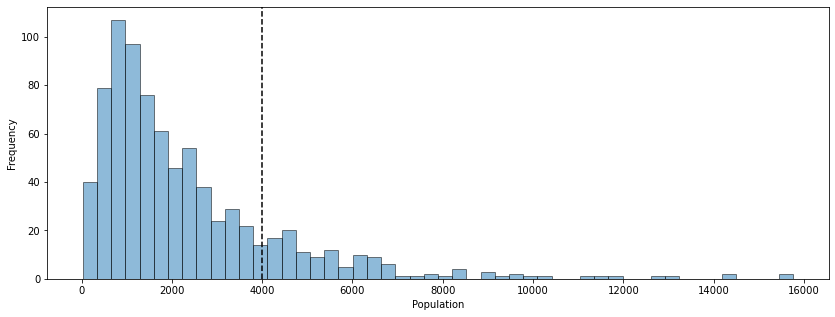

In [26]:
# We create a new figure
fig, ax = plt.subplots(figsize=(14, 5))

# We plot an histogram based on the 'population_sum' column
ax.hist(public_health_care["Population_sum"],
        bins=50,
        alpha=0.5,
        edgecolor='black')

# Draw a vertical line at population=4000
ax.axvline(x=4000, color='k', linestyle='--')
ax.set_xlabel("Population")
ax.set_ylabel("Frequency")

plt.show()

## Identifying areas above target
---
To finish, we just need to select voronoi areas where we have more than 4000 women of child-bearing age.

In [27]:
outliers = voronoi_polygons[voronoi_polygons["Population_sum"] > 4000]

And using the different element we have already created, add our outliers to the interactive map:

In [28]:
map_final = voronoi_polygons.explore(
    color="black",  # Use black color for borders.
    # Styling instructions. We fill the wards with lightgrey color (when hovering over them),
    # and change the opacity of different elements.
    style_kwds=dict(fillColor="lightgrey",
                    fill=True,
                    opacity=1.,
                    fillOpacity=0,
                    interactive=True),
    tiles="openstreetmap",  # Use "Open Street Map" background tiles.
    tooltip=False,  # Do not show tooltip when hovering on wards.
    popup="Population_sum",  # show population values in popup (on click).
    popup_kwds=dict(labels=True),  # Show column label in the popup.
    smooth_factor=0,  # Prevent smoothing of the polygons edges.
    name="voronoi"  # Name of the layer in the map.
)

outliers.explore(
    m=map_final,  # Pass the previous map object 'map_final'.
    color="black",  # Use black color for borders.
    # Styling instructions. We fill the outlier wards with red color,
    # and change the opacity of different elements.
    style_kwds=dict(fillColor="red",
                    fill=True,
                    opacity=0.,
                    fillOpacity=0.5,
                    interactive=True),
    tooltip=False,  # Do not show tooltip when hovering on wards.
    popup="Population_sum",  # Show population values in popup (on click).
    popup_kwds=dict(labels=True),  # Show column label in the popup.
    smooth_factor=0,  # Prevent smoothing of the polygons edges.
    name="wards"  # Name of the layer in the map.
)

public_health_care.explore(
    m=map_final,  # Pass the previous map object 'map_final'.
    column="category",  # Make choropleth based on "category" column.
    tooltip="name",  # Show "name" value in tooltip (on hover).
    # Do not show column label in the tooltip.
    tooltip_kwds=dict(labels=False),
    popup=True,  # Show the selected values in popup (on click).
    cmap="gnuplot2",  # Use "gnuplot2" matplotlib color scheme.
    marker_kwds=dict(radius=5),  # Size of the points.
    # Styling instructions. We draw small black circles around our points,
    # and change the opacity of different elements.
    style_kwds=dict(color="black",
                    weight=1,
                    fill=True,
                    opacity=0.5,
                    fillOpacity=0.8),
    name="health_care"  # Name of the layer in the map.
)

folium.LayerControl().add_to(map_final)  # use folium to add layer control

In [29]:
map_final